<a href="https://colab.research.google.com/github/victor-bastos/DataScienceIntroduction/blob/main/LAB3/Lab3_CMC_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CMC-13 Lab. 3: Aprendizado de Máquina Probabilístico

##   Victor Hugo de Oliveira Bastos



# Table of Content

* [Modelo Probabilístico](#prep)
  * [Importação de pacotes e carregamento dos dados](#imp)
  * [Primeira análise](#ana)
  * [Valores nulos](#nulo)
  * [Criando o modelo](#modelo)
  * [Avaliando o modelo](#modelo)
* [Criação do Ranking](#anexp)
  * [Importancia das features](#importancia)
* [Conclusões](#conclusoes)



<a name='prep'></a>
# 1 - Modelo Probabilístico



<a name='imp'></a>
## Importando pacotes e dados

In [ ]:
# Load the necessary python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing train_test_split
from sklearn.model_selection import train_test_split

# Ordinal encoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

# Discretizer
from sklearn.preprocessing import KBinsDiscretizer

# Min-max scaler
from sklearn.preprocessing import MinMaxScaler

# Import classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

# Import metrics
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score
)

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Import transformers
from sklearn.preprocessing import PowerTransformer, FunctionTransformer
from sklearn.impute import SimpleImputer

# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set plot style
plt.style.use('ggplot')

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Por conveniência, optou-se por armazenar e realizar a leitura dos arquivos de dados pelo Google Drive. A leitura como *dataframe* já ignora quaisquer linhas possam conter erros iniciais.

In [ ]:
# Definindo o caminho dos arquivos
path_files = '/content/drive/MyDrive/Colab Notebooks/Lab2_CMC-13/'

# URL do arquivo de teste
url_test = 'https://drive.google.com/file/d/1cWmXv2Y1dG7xSZS2PjqhnTeVrbP1QfGR/view?usp=sharing'
url_test = 'https://drive.google.com/uc?id=' + url_test.split('/')[-2]

# URL do arquivo de treinamento
url_train = "https://drive.google.com/file/d/1Ln0pjp2YL4xXAezZnGidQlYQm4qp5wdc/view?usp=sharing"
url_train = 'https://drive.google.com/uc?id=' + url_train.split('/')[-2]

# Carregando o conjunto de treinamento a partir do arquivo CSV
X_train = pd.read_csv(url_train, on_bad_lines='skip', sep=',')
# O argumento 'on_bad_lines' é definido como 'skip' para pular linhas inválidas ou com problemas durante a leitura
# O separador é definido como ','

# Carregando o conjunto de teste a partir do arquivo CSV
X_test = pd.read_csv(url_test, on_bad_lines='skip', sep=';')


<a name='ana'></a>
## Primeira análise

Inicia-se a análise visualizando o aspecto geral que o *dataset* de treino possui, exibindo apenas as 5 primeiras linhas deste.

In [ ]:
X_train.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,religious-groups-in-schools,anti-satellite-test-ban,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa,Target
0,n,y,n,y,y,n,n,y,?,y,y,y,n,y,republican
1,n,y,n,y,y,n,n,n,n,y,y,y,n,?,republican
2,?,y,y,?,y,n,n,n,y,n,y,y,n,n,democrat
3,n,y,y,n,y,n,n,n,y,n,y,n,n,y,democrat
4,y,y,y,n,y,n,n,n,y,?,y,y,y,y,democrat


Para prosseguir com a visualização do *dataset*, constrói-se os histogramas a fim de permitir a observação das opiniões dos eleitores democratas e republicanos.

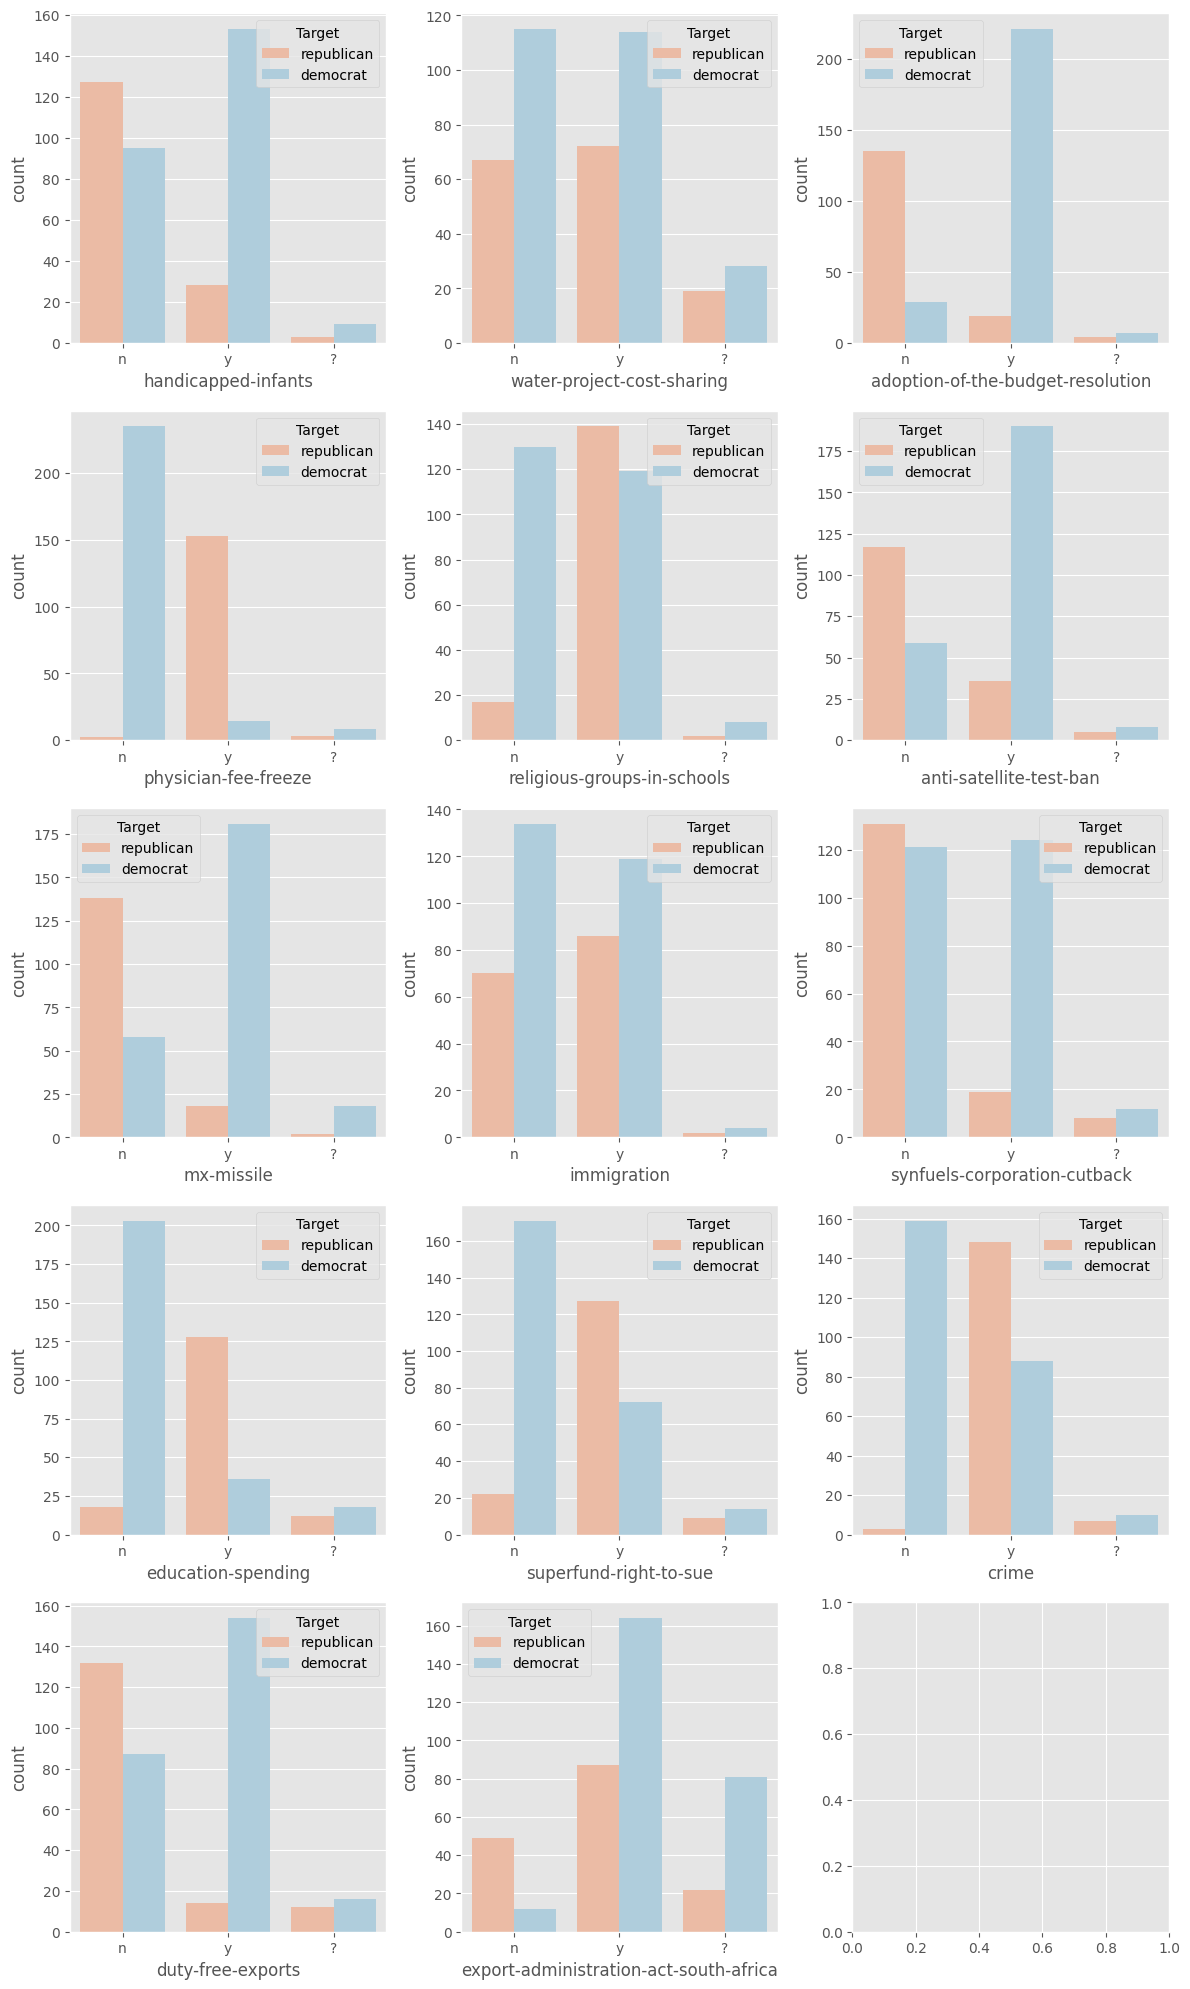

In [ ]:
# Lista de colunas a serem plotadas
columns = [col for col in X_train.columns if col != 'Target']
order = ['n','y','?']

# Configuração do layout dos subplots
nrows = 5
ncols = 3

# Criação dos subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()

# Loop para plotar os gráficos
for i, col in enumerate(columns):
    sns.countplot(x=col, hue='Target', data=X_train, palette='RdBu', order=order, ax=axes[i])

# Ajuste de layout e exibição dos subplots
plt.tight_layout()
plt.show()

Torna-se perceptível que existe forte relação entre a decisão de voto e as opiniões políticas sobre cada um dos temas abordados. Nota-se ainda que em alguns assuntos, os valores faltantes (possíveis abstenções) podem revelar mais informações posteriormente.

Em resumo, observa-se que nos assuntos abaixo, há um resultado claro para pelo menos um dos lados políticos.

*   Adoption of the Budget Resolution
*   Physician Fee Freeze
*   Anti-Satellite Test Ban
*   MX Missile
*   Education Spending
*   Superfund Right-to-Sue
*   Crime
*   Duty-Free Exports

Nos outros assuntos analisados, as opiniões de um mesmo lado político podem ser conflitantes, não resultando numa distribuição favorável, como se observa no assunto de imigração e 'Synfuels Corporation Cutback'.


<a name='nulo'></a>
## Valores nulos

Para o tratamento das abstenções, opta-se por utilizar um preenchimento de dados baseado no *SimpleImputer* que deduzirá a informação faltante segundo o resultado mais frequente. Ademais, faz-se uma codificação (*encoding*) para adotar 'Sim (y)' como 1 e 'Não (n)' como 0.

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# Criar um objeto SimpleImputer para imputar valores ausentes utilizando a estratégia 'most_frequent'

y = X_train['Target']
X = X_train.drop(columns=['Target'])

# Separar o alvo (variável dependente) do conjunto de treinamento (X_train) e extrair a coluna 'ID' do conjunto de teste (X_test)
id = X_test['ID']
X_test.drop(columns=['ID'], inplace=True)

colunas = X.columns

# Substituir os valores 'n' por 0, 'y' por 1 e '?' por NaN (valores ausentes) em ambos os conjuntos (X e X_test)
for df in [X, X_test]:
    df.replace(['n', 'y', '?'], [0, 1, np.nan], inplace=True)


# Ajustar o imputer aos dados de treinamento (X) para aprender a estratégia de imputação mais frequente
imputer.fit(X)

# Imputar os valores ausentes utilizando a estratégia 'most_frequent' nos conjuntos X e X_test e convertê-los de volta em DataFrames do pandas
X = pd.DataFrame(imputer.transform(X), columns=colunas)
X_test = pd.DataFrame(imputer.transform(X_test), columns=colunas)

Após o tratamento dos valores faltantes, visualiza-se o aspecto do *dataset*, para confirmar o resultado esperado.

In [ ]:
X.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,religious-groups-in-schools,anti-satellite-test-ban,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0


<a name='modelo'></a>
## Criando o modelo

O modelo escolhido para esta tarefa foi **Bernoulli Naive Bayes**, um  algoritmo que assume que todas as características analisadas são independentes entre si, ou seja, a presença/ausência de uma característica não afeta a presença/ausência de outras características. Tal variante do algoritmo **Naive Bayes** é especialmente adequada para dados binários ou categóricos, pois tais dados sempre serão analisados como valores booleanos.

O primeiro passo para iniciar a construção do modelo foi dividir o *dataset* a fim de evitar *overfitting*.

In [ ]:
#Dividindo o dataset para evitar ovefitting
X_train, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

A criação do modelo é realizada por meio do método **BernoulliNB** presente na biblioteca *sklearn*.

O parâmetro **force_alpha=True** nesta implementação indica que o modelo está sendo configurado para forçar a adição de um valor alfa à estimativa de probabilidade. O parâmetro alfa é um hiperparâmetro que controla a suavização do modelo para evitar a probabilidade zero em casos onde não há evidências suficientes para calcular uma probabilidade adequada.

In [ ]:
modelo = BernoulliNB(force_alpha=True)

modelo.fit(X_train, y_train)

BernoulliNB(force_alpha=True)

<a name='avaliando'></a>
## Avaliando o modelo

A fim de testar o modelo, utiliza-se a parte do conjunto de dados **X_test_**, que foi anteriormente separada para com esse propósito. A visualização de desempenho é feita por uma matriz de confusão.

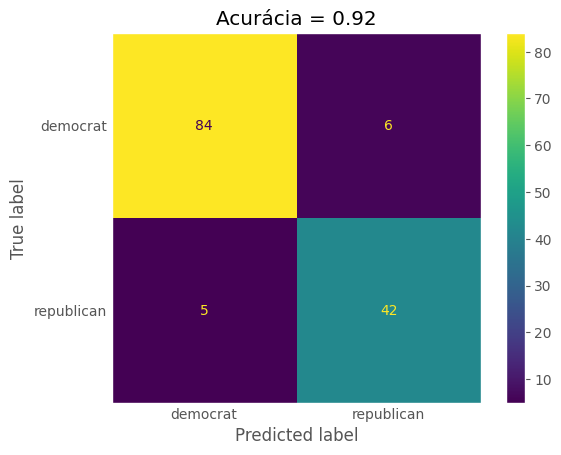

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
# Importar as classes necessárias para cálculo e exibição da matriz de confusão e acurácia

predictions = modelo.predict(X_test_)
# Fazer previsões utilizando o modelo treinado nos dados de teste

cm = confusion_matrix(y_test, predictions, labels=modelo.classes_)
# Calcular a matriz de confusão com base nas previsões e nos valores reais do conjunto de teste

accuracy = accuracy_score(y_test, predictions)
# Calcular a acurácia comparando as previsões com os valores reais do conjunto de teste

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo.classes_)
# Criar um objeto ConfusionMatrixDisplay para exibir a matriz de confusão

disp.plot()
# Plotar a matriz de confusão utilizando o objeto ConfusionMatrixDisplay

plt.tick_params(axis=u'both', which=u'both', length=0)
# Configurar os parâmetros dos ticks dos eixos

plt.grid(None)
# Desabilitar as linhas de grade do gráfico

plt.title(f"Acurácia = {accuracy:.2f}")
# Definir o título do gráfico com o valor da acurácia formatado com duas casas decimais

plt.show()
# Exibir o gráfico da matriz de confusão


Assim, é possível observar que o modelo teve um excelente desempenho.

<a name='anexp'></a>
#2 - Criação do Ranking

Dado que o modelo está aprovado, com 92% de precisão, inicia-se a análise probabilística de que um certo eleitor seja republicano. Para isso, considera-se o conjunto de dados completo.

In [ ]:
#Retreinando o modelo com os dados todos
modelo = BernoulliNB(force_alpha=True)
modelo.fit(X, y)

#Array de probabilidades
probabilidades = modelo.predict_proba(X_test)

Com isso, elabora-se o *ranking* dos eleitores com base na respectiva probabilidade de serem republicanos.

In [ ]:
# Criar um DataFrame vazio com as colunas 'ID' e 'P(Republicano)'
tabela = pd.DataFrame(columns=['ID', 'P(Republicano)'])

# Preencher a coluna 'P(Republicano)' com os valores de probabilidade obtidos
tabela['P(Republicano)'] = [item[1] for item in probabilidades]

# Preencher a coluna 'ID' com os valores da variável 'id'
tabela['ID'] = id

# Ordenar o DataFrame pela coluna 'P(Republicano)' em ordem decrescente
tabela = tabela.sort_values(by='P(Republicano)', ascending=False).reset_index(drop=True)
tabela['P(Republicano)_aprox'] = 100*tabela['P(Republicano)'].round(6)

# Atualizar os índices do DataFrame começando em 1
tabela.index = tabela.index + 1

# Exibir o DataFrame resultante
tabela

,ID,P(Republicano),P(Republicano)_aprox
1,108,9.999996e-01,100.0000
2,112,9.999973e-01,99.9997
3,118,9.999780e-01,99.9978
4,110,9.999759e-01,99.9976
5,106,9.999747e-01,99.9975
6,102,9.995917e-01,99.9592
7,120,9.994338e-01,99.9434
8,116,9.973769e-01,99.7377
9,114,8.586431e-01,85.8643
10,104,8.586431e-01,85.8643


Assim, evidencia-se pelo ranking que há cerca de 10 democratas e 10 republicanos, um resultado muito próximo da realidade exposta pelas informações adicionais concedidas, onde consta 45% de democratas.

<a name='importancia'></a>
##Importância das features

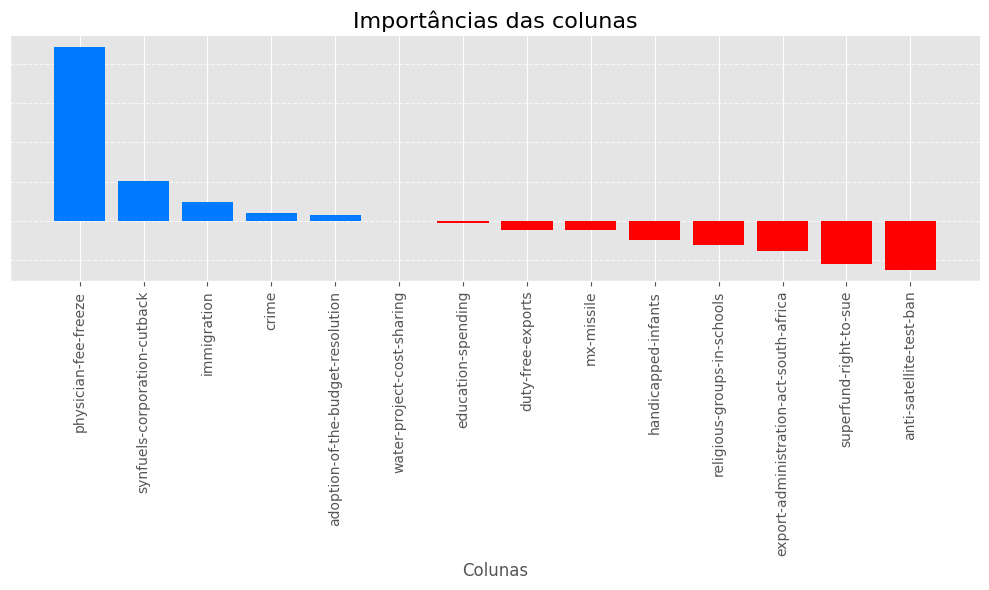

In [ ]:
from sklearn.inspection import permutation_importance

# Utilizando a função que calcula as importâncias
imps = permutation_importance(modelo, X, y)
importancias = imps.importances_mean

# Nomes das colunas
column_names = X.columns

# Ordenar as importâncias e as colunas em ordem decrescente
importancias, column_names = zip(*sorted(zip(importancias, column_names), reverse=True))

# Configurar o gráfico de barras
plt.figure(figsize=(10, 6), facecolor='white')  # Tamanho da figura (opcional) e fundo branco

# Definir as cores das barras com base nos valores das importâncias
colors = ['#FF0000' if imp < 0 else '#007BFF' for imp in importancias]

# Criar as barras com as cores definidas
bars = plt.bar(column_names, importancias, color=colors)

# Personalizar o gráfico
plt.title('Importâncias das colunas', fontsize=16)  # Título do gráfico
plt.xlabel('Colunas', fontsize=12)  # Rótulo do eixo x
plt.xticks(rotation='vertical', fontsize=10)  # Rotacionar as legendas do eixo x verticalmente
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adicionar um grid de fundo
plt.gca().spines['top'].set_visible(False)  # Remover a borda superior
plt.gca().spines['right'].set_visible(False)  # Remover a borda direita

# Remover os ticks do eixo y
plt.tick_params(axis='y', which='both', left=False, labelleft=False)

# Mostrar o gráfico
plt.tight_layout()  # Ajustar o layout
plt.show()

<a name='conclusoes'></a>
#3 - Conclusões

Nesta atividade, foi realizada a tarefa de criar um modelo probabilístico baseado em Naive Bayes para estimar a probabilidade de um indivíduo ser republicano com base em seus votos em questões relevantes do Congresso. O algoritmo escolhido foi o *Bernoulli Naive Bayes* e os valores faltantes foram deduzidos com base nos mais frequentes.

Ao testar o modelo, foi obtida uma precisão de 92%, o que indica que ele é capaz de fazer boas previsões com base nos dados fornecidos. Dessa forma, a escolha do algoritmo *Bernoulli Naive Bayes* foi considerada adequada para esse problema, já que o conjunto de dados lidava com variáveis binárias ('sim' ou 'não').  No entanto, algumas sugestões para melhorias seriam explorar outros métodos de aprendizado probabilístico e realizar uma análise mais detalhada do conjunto de dados antes da modelagem. Outra sugestão seria eliminar algumas features que foram acusadas como não significativas na seção de importância das features.

Para criar o ranking, ordenaram-se os identificadores dos indivíduos em ordem decrescente de probabilidade de serem republicanos, o que possibilitou identificar os indivíduos mais propensos a serem republicanos com base em seus votos. Assim, o laboratório permitiu o exercício dos conhecimentos sobre Ciência de Dados e sobre preparação de dados, além de ter sido interessante aplicar o algoritmo *Naive Bayes* em um cenário prático e obter resultados satisfatórios em termos de precisão.

Portanto, a atividade demonstrou a importância da imputação de valores faltantes para garantir que o modelo seja treinado com dados completos, sendo que a estratégia de imputar por meio dos valores mais frequentes foi eficaz para esse conjunto de dados, conforme demonstrado pelas métricas avaliadas. O trabalho foi desafiador, mas proporcionou uma experiência prática valiosa na aplicação de aprendizado de máquina probabilístico em um problema real.